In [58]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox

from scipy.stats.distributions import chi2 

from math import sqrt
import seaborn as sns
sns.set()

In [59]:
# load data
dengue_weather = pd.read_csv('../../assets/cleaned_comb_changi_weather.csv', parse_dates=[0], index_col='date')

In [60]:
# preview
dengue_weather.head()

,type_dengue,year,month,number,Year,Month,Day,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Mean Temperature (°C),Maximum Temperature (°C),Minimum Temperature (°C),Mean Wind Speed (km/h),Max Wind Speed (km/h),week
date,,,,,,,,,,,,,,,,,
2014-01-06,Dengue,2014,1,436.0,2014,1,6,31.2,10.0,10.8,11.6,25.3,27.1,23.9,6.1,25.6,2
2014-01-06,DHF,2014,1,1.0,2014,1,6,31.2,10.0,10.8,11.6,25.3,27.1,23.9,6.1,25.6,2
2014-01-13,Dengue,2014,1,479.0,2014,1,13,0.0,0.0,0.0,0.0,26.9,30.3,25.4,14.6,40.0,3
2014-01-13,DHF,2014,1,0.0,2014,1,13,0.0,0.0,0.0,0.0,26.9,30.3,25.4,14.6,40.0,3
2014-01-20,Dengue,2014,1,401.0,2014,1,20,0.0,0.0,0.0,0.0,25.7,29.1,23.6,11.7,38.2,4


In [61]:
# filter dengue cases only
dengue_only=dengue_weather.loc[dengue_weather['type_dengue']=='Dengue'].drop(columns=['type_dengue'])

In [62]:
# keep number 'number' only
dengue_only = dengue_only[['number']]

In [63]:
dengue_only.index = pd.to_datetime(dengue_only.index)
dengue_only = dengue_only.resample('W').sum()

In [64]:
# ADF to check stationary
result = adfuller(dengue_only['number'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.653206
p-value: 0.082492
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573


In [65]:
# determine stationary
if result[1] > 0.05:
    print('The time series is not stationary.')
else:
    print('The time series is stationary.')

The time series is not stationary.


In [66]:
# difference if not stationary
if result[1] > 0.05:
    dengue_only_diff = dengue_only.diff().dropna()
else:
    dengue_only_diff = dengue_only.copy()

# ARIMA

In [67]:
# Split data into training and testing sets
train_size = int(len(dengue_only) * 0.8)  # 80% for training
train = dengue_only.iloc[:train_size]
test = dengue_only.iloc[train_size:]

# Check the size of the train and test sets
print("Training set size:", len(train))
print("Testing set size:", len(test))

Training set size: 208
Testing set size: 52


In [68]:
# fit ARIMA
model = ARIMA(dengue_only_diff, order=(1, 1, 1))
model_fit = model.fit()

In [69]:
# Generate forecasts for testing set
forecast = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

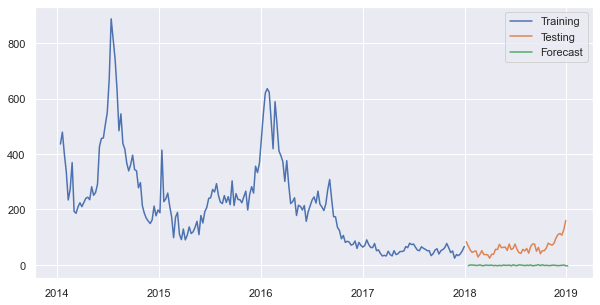

In [70]:
# Plot forecasts
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['number'])
plt.plot(test.index, test['number'])
plt.plot(forecast.index, forecast)
plt.legend(['Training', 'Testing', 'Forecast'])
plt.show()

In [71]:
# model summary for ARIMA
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 number   No. Observations:                  259
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1362.059
Date:                Sun, 09 Apr 2023   AIC                           2730.118
Time:                        14:43:55   BIC                           2740.777
Sample:                    01-19-2014   HQIC                          2734.404
                         - 12-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0886      0.033     -2.699      0.007      -0.153      -0.024
ma.L1         -1.0000      7.393     -0.135      0.892     -15.491      13.491
sigma2      2205.1515   1.63e+04      0.135      0.8

___Findings:___
- AIC and BIC values suggest that the model fits the data reasonably well.
- However, the MA coefficient is estimated as -1.0000, which could indicate overfitting with the model. 

In [72]:
# get residuals
residuals = model_fit.resid

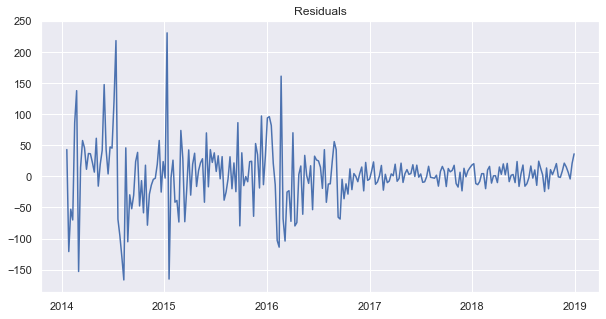

In [73]:
# plot residuals
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Residuals')
plt.show()

/Users/nicholas/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


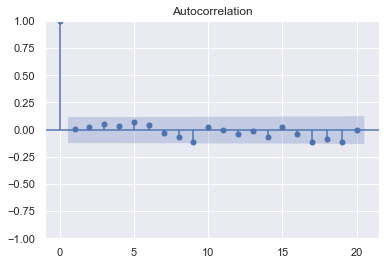

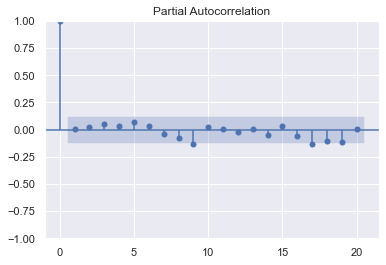

In [74]:
# plot ACF and PACF of residuals
plot_acf(residuals, lags=20, alpha=0.05)
plot_pacf(residuals, lags=20, alpha=0.05)
plt.show()

# SARIMA Without Exo

In [75]:
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
model_fit = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.23124D+00    |proj g|=  7.20743D-02

At iterate    5    f=  5.20578D+00    |proj g|=  5.51249D-03

At iterate   10    f=  5.15594D+00    |proj g|=  6.28899D-02

At iterate   15    f=  5.13057D+00    |proj g|=  3.07238D-03

At iterate   20    f=  5.12837D+00    |proj g|=  1.34879D-02

At iterate   25    f=  5.12810D+00    |proj g|=  7.88436D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     30      1     0     0   

In [76]:
# Generate forecasts for testing set
forecast = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

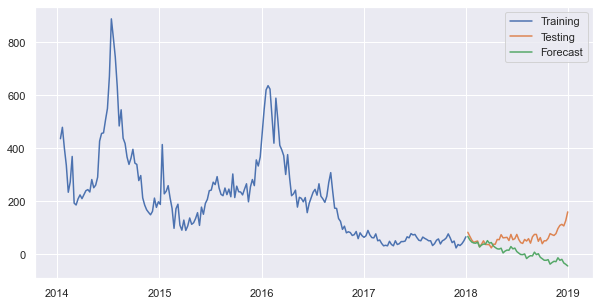

In [77]:
# Plot forecasts
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['number'])
plt.plot(test.index, test['number'])
plt.plot(forecast.index, forecast)
plt.legend(['Training', 'Testing', 'Forecast'])
plt.show()

In [78]:
# model summary for SARIMA without Exo
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             number   No. Observations:                  208
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1066.645
Date:                            Sun, 09 Apr 2023   AIC                           2143.290
Time:                                    14:43:56   BIC                           2159.655
Sample:                                01-12-2014   HQIC                          2149.916
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9851      0.141     -6.999      0.000      -1.261      -0.709
ma.L1          0.9673      0.130   

___Findings:___
- Seasonal components ar.S.L12 and ma.S.L12 are high, meaning they are not statistically significant.
- Seasonal component may not be significiant and removing it may not affect overall performance.

# SARIMAX

In [79]:
# load data
df = pd.read_csv('../../assets/cleaned_comb_changi_weather.csv', parse_dates=[0], index_col='date')

In [80]:
# exo variables
exog_cols = ['Daily Rainfall Total (mm)', 'Highest 30 Min Rainfall (mm)',
             'Highest 60 Min Rainfall (mm)', 'Highest 120 Min Rainfall (mm)',
             'Mean Temperature (°C)', 'Maximum Temperature (°C)',
             'Minimum Temperature (°C)', 'Mean Wind Speed (km/h)',
             'Max Wind Speed (km/h)']

In [81]:
# dengue only with exog cols and "number"
df_dengue = df.loc[df['type_dengue'] == 'Dengue', exog_cols + ['number']]

In [82]:
# set index to date
df_dengue.index = pd.to_datetime(df_dengue.index)

# resample to weekly
df_dengue_weekly = df_dengue.resample('W').sum()

In [83]:
# split dataset
train_size = int(len(df_dengue_weekly) * 0.8)  # 80% for training
train = df_dengue_weekly.iloc[:train_size]
test = df_dengue_weekly.iloc[train_size:]

In [84]:
# fit SARIMAX model with exogenous variables
order = (1, 1, 1)
seasonal_order = (1, 0, 1, 52)
model = SARIMAX(train['number'], exog=train[exog_cols], order=order, seasonal_order=seasonal_order)
model_fit = model.fit()

/Users/nicholas/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/nicholas/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/nicholas/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.25026D+00    |proj g|=  7.72753D-02

At iterate    5    f=  5.24306D+00    |proj g|=  2.41340D-02

At iterate   10    f=  5.23857D+00    |proj g|=  1.10445D-02

At iterate   15    f=  5.23770D+00    |proj g|=  1.11300D-02

At iterate   20    f=  5.23685D+00    |proj g|=  4.07076D-03

At iterate   25    f=  5.23628D+00    |proj g|=  3.15006D-03

At iterate   30    f=  5.23613D+00    |proj g|=  1.25352D-03

At iterate   35    f=  5.23601D+00    |proj g|=  5.36020D-04

At iterate   40    f=  5.23594D+00    |proj g|=  1.02990D-03

At iterate   45    f=  5.23590D+00    |proj g|=  8.39920D-04


/Users/nicholas/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  5.23585D+00    |proj g|=  2.40962D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   14     50     56      1     0     0   2.410D-04   5.236D+00
  F =   5.2358491021041207     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


In [85]:
# generate forecasts
forecast = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, exog=test[exog_cols])

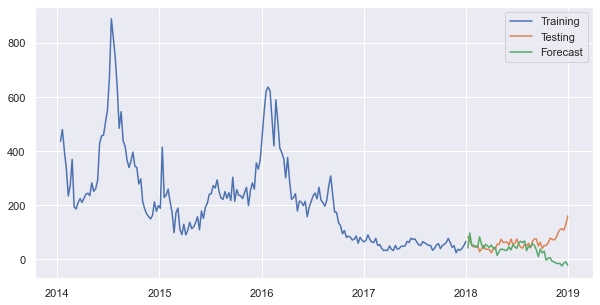

In [86]:
# plot forecasts
plt.figure(figsize=(10, 5))
plt.plot(train.index, train['number'])
plt.plot(test.index, test['number'])
plt.plot(forecast.index, forecast)
plt.legend(['Training', 'Testing', 'Forecast'])
plt.show()

In [87]:
# model summary for SARIMAX
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:                             number   No. Observations:                  208
Model:             SARIMAX(1, 1, 1)x(1, 0, 1, 52)   Log Likelihood               -1089.057
Date:                            Sun, 09 Apr 2023   AIC                           2206.113
Time:                                    14:44:05   BIC                           2252.771
Sample:                                01-12-2014   HQIC                          2224.981
                                     - 12-31-2017                                         
Covariance Type:                              opg                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Daily Rainfall Total (mm)        -0.4788      1.878     -0.255      0.799   